## Benchmark Result
![BenchmarkResult](result.png)

## Q1
Only using the second half of the measurements can remove one-time costs like cache population, branch predictor trainning, etc.
The expected consequence will be more stable, less variance. Then we can get more accurate result

Arithmetic mean. Because the accumulated time of repeated program is just simply added.


In [33]:
performance_data = [2095846912, 2111939584, 6077614592, 4741038080, 45017899008, 14124459008, 10011187.803507876, 9654363.687990008, 13994494064.94139, 5540951577.306882]
labels = ['dp1 N=1000000', 'dp1 N=300000000', 'dp2 N=100000', 'dp2 N=300000000', 'dp3 N=1000000', 'dp3 N=300000000', 'dp4 N=1000000', 'dp4 N=300000000', 'dp5 N=1000000', 'dp5 N=300000000']
colors = ['red','orange','blue','green', 'purple']
cur_arithmetic_intensity = 0.25
# FLOPs/byte = 2 / 8

## Q2

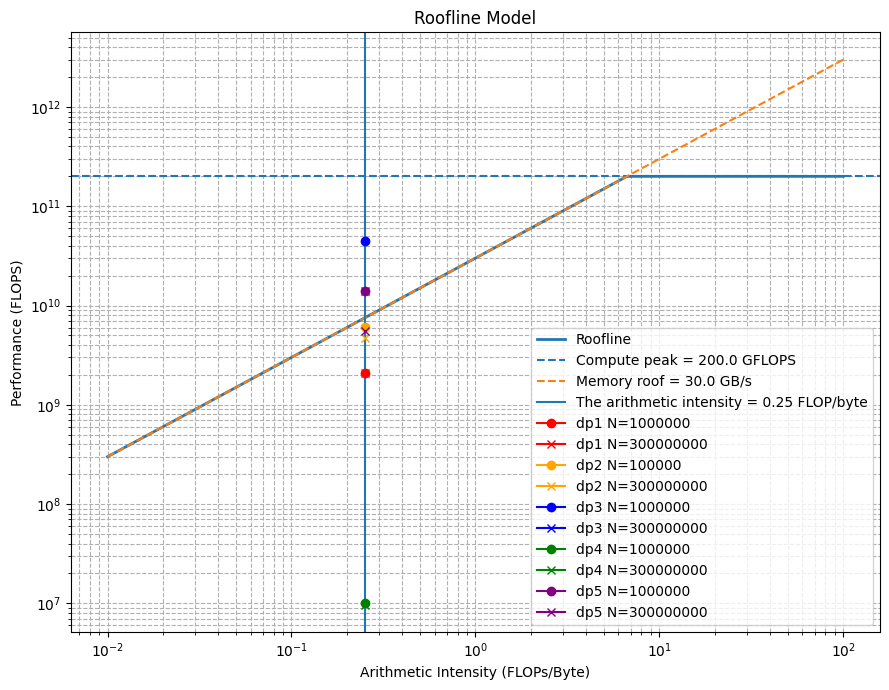

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- parameters ---
peak_flops = 200.0*1e9    # GFLOPS
bandwidth_bs = 30.0*1e9   # GB/s

# x-range (operational intensity)
ai = np.logspace(-2, 2, 400)  # 0.01 .. 100 FLOPs/Byte

# roofline = min(compute ceiling, memory roof)
perf_mem = ai * bandwidth_bs
perf_roof = np.minimum(peak_flops, perf_mem)

# --- plot ---
plt.figure(figsize=(9,7))
plt.loglog(ai, perf_roof, linewidth=2, label="Roofline")
plt.axhline(peak_flops, linestyle="--", label=f"Compute peak = {peak_flops/1e9} GFLOPS")
plt.loglog(ai, perf_mem, linestyle="--", label=f"Memory roof = {bandwidth_bs/1e9} GB/s")
plt.axvline(cur_arithmetic_intensity, label = f"The arithmetic intensity = {cur_arithmetic_intensity} FLOP/byte")

for i in range(len(performance_data)):
    if i % 2 == 0:
        marker = "o"
    else:
        marker = "x"

    plt.loglog(0.25, performance_data[i], marker=marker, color=colors[(int)(i/2)], label=labels[i])

# labels & styling
plt.xlabel("Arithmetic Intensity (FLOPs/Byte)")
plt.ylabel("Performance (FLOPS)")
plt.title("Roofline Model")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


Memory bound. Because these programs haven't hit the compute peak. The performance is limited by data movement and will increase if memory bandwidth increases.
The performance of these computations differs. The performance of different N in the same program differs, maybe because more cache misses, NUMA, etc. Other detailed reasons are in Q3.

Underperformed microbenchmarks: dp1, dp2, dp4, dp5 N = 300000000

## Q3
The performance of each program in decreasing order is as follows.
dp3 I think MKL do a lot of optimization in cblas_sdot besides loop unroll so it's fast. According to ChatGPT, MKL utilizes vectorization, loop unrolling, FMA, memory access optimizations.
dp5 The same as dp3. According to the result, MKL does better. According to ChatGPT, numpy calls BLAS(MKL, OpenBLAS, BLIS, cuBLAS)
dp2 uses loop unroll. So CPU can parallelize four adding operation and less branch prediction will happen.
dp1 
dp4 Python need to do a bunch of extra work to run 'a+b' because it's an interpreted language. For example: check the type of a, find the addition function, allocate a new object, etc. And 'a+b' is just one instruction in C.


## Q4
The results of C1, C2, and C4 with N=300000000 are wrong and the rest are correct.
Floating point operations have errors. So while we accumulate float by 300,000,000 times, the error accumulate at the same time which makes huge bias exist.
I tried to use double instead float and the error dissappeared.